<a href="https://colab.research.google.com/github/KilluJ/nlp-projects/blob/main/Movie_recommender_based_on_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data

In this project we use data from MovieLens to build a model-based CF movie recommender.

In [43]:
# inspired by https://colab.research.google.com/github/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Item_based_Collaborative_Recommender_System_using_KNN.ipynb#scrollTo=lgyPInMAwQAv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from pprint import pprint

pd.set_option('expand_frame_repr', False)

In [2]:
movies = pd.read_csv('./movies.csv')
movies_archive = movies.copy()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('./ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
refined_rating = ratings.groupby(by=['userId','movieId'], as_index=False).agg({"rating":"mean"})
refined_rating.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [5]:
movies.shape, ratings.shape, refined_rating.shape

((9742, 3), (100836, 4), (100836, 3))

It looks there is no user rated a single movie twice.

## EDA

In [6]:
num_users = len(refined_rating['userId'].value_counts())
num_items = len(refined_rating['movieId'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the rating dataset: {}'.format(num_items))

Unique number of users in the dataset: 610
Unique number of movies in the rating dataset: 9724


In [7]:
rating_count_df = pd.DataFrame(refined_rating.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, 'number of ratings')

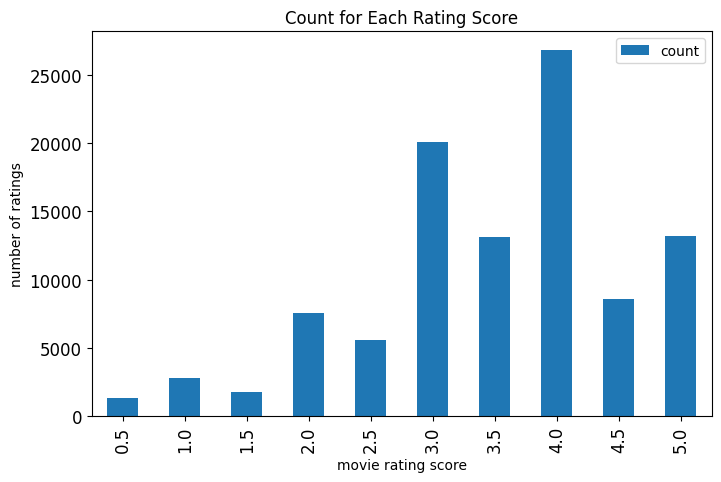

In [8]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(8, 5),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [9]:
total_count = num_items * num_users
zero_count = total_count - refined_rating.shape[0]
zero_count

5830804

In [10]:
# append counts of zero rating to df_ratings_cnt
rating_count_df = pd.concat([rating_count_df,
    pd.DataFrame({'count': zero_count}, index = [0.0])],
    verify_integrity = True,
).sort_index()
rating_count_df

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [11]:
# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


In [12]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating score,count,log_count
0,0.0,5830804,15.578665
1,0.5,1370,7.222566
2,1.0,2811,7.941296
3,1.5,1791,7.490529
4,2.0,7551,8.929435
5,2.5,5550,8.621553
6,3.0,20047,9.905835
7,3.5,13136,9.483112
8,4.0,26818,10.196829
9,4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

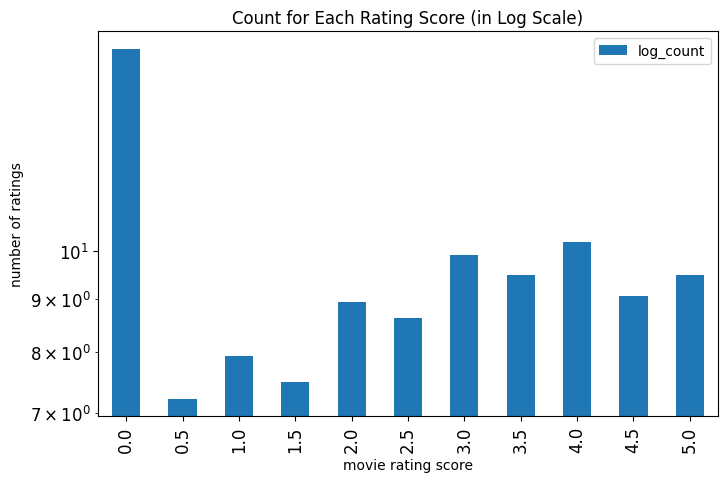

In [13]:
ax = rating_count_df.plot('rating score', 'log_count', 'bar', figsize=(8,5),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [14]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_rating.groupby('movieId').size(), columns=['count'])
movies_count_df.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

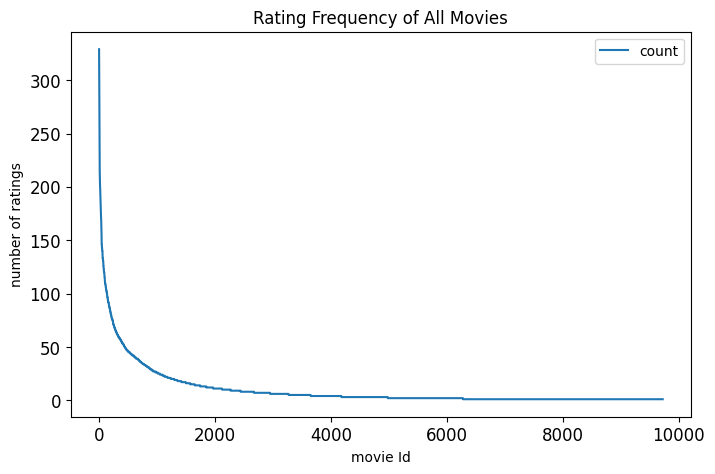

In [15]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(8, 5),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

## Pivot

In [16]:
# adjust ratings so that movies rated low (1, 2) get negative weights
# movies rated kinda neutral 3 get weight 0.5
# movies received positive ratings 4, 5 get high weights
def reweight(x):
    if x < 3:
        return -(x - 2.5)**2
    else:
        return (x - 2.5)**2
refined_rating['rating'] = refined_rating['rating'].apply(reweight)
refined_rating.head()

,userId,movieId,rating
0,1,1,2.25
1,1,3,2.25
2,1,6,2.25
3,1,47,6.25
4,1,50,6.25


In [17]:
# pivot and create movie-user matrix
user_to_movie_df = refined_rating.pivot(
    index='userId',
     columns='movieId',
      values='rating').fillna(0)

user_to_movie_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.25,0.0,2.25,0.0,0.0,2.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.25,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 95286 stored elements in Compressed Sparse Row format>

## Fitting KNN model

In [19]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

## Recommender


*   we build a recommender based on collaborative filtering.
*   reweight the movies by popularity (number of ratings, movies getting more votes will be weighted down more)
*   If there is not enough movies, we simply add most popular movies to the tail of the recommended list
*   where `popularity` is meatured by sum of ratings received by the movie.





In [20]:
# movie list
movies_list = list(user_to_movie_df.columns)

In [21]:
# popularity table for reweighting purpose
popular = ratings.groupby(by=['movieId'], as_index=False).agg({"userId":"count"})
popular = np.array(popular[['userId']])
popular = np.reshape(popular, (len(popular))) # a 1D np.array of length = # rated movies

In [23]:
# best movies to recommend whenever there is not enough movies to recommend by CF
best = ratings.groupby(by=['movieId'], as_index=False).agg({"rating":"sum"})
best = best.sort_values(by = 'rating', ascending = False)
best.head()

,movieId,rating
277,318,1404.0
314,356,1370.0
257,296,1288.5
1938,2571,1165.5
510,593,1161.0


In [45]:
def recommender_system(user_id, n_similar_users = 5, n_movies = 10): #, user_to_movie_df, knn_model):

    # print history of the specified user
    print("Movie liked (rated 5) by User {} (displaying at most 15 for reference):".format(user_id))
    watched_id = list(refined_rating.loc[(refined_rating['userId'] == user_id) & (refined_rating['rating'] > 3)]['movieId']) # movie ids
    pprint(movies.loc[movies['movieId'].isin(watched_id)][['title', 'genres']].head(15))
    print("")

    print("Movie disliked (rated 1 or 2) by User {} (displaying at most 10 for reference):".format(user_id))
    watched_id = list(refined_rating.loc[(refined_rating['userId'] == user_id) & (refined_rating['rating'] < 0)]['movieId']) # movie ids
    pprint(movies.loc[movies['movieId'].isin(watched_id)][['title', 'genres']].head(10))
    print("")

    # function to find top n similar users of the given input user
    def get_similar_users(user, n = n_similar_users):
        ## input to this function is the user and number of top similar users you want.

        knn_input = np.asarray([user_to_movie_df.values[user - 1]])  #.reshape(1,-1)
        # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors = n+1)

        print("Top", n, "users who are very much similar to User-", user, "are: ")
        print(" ")
        for i in range(1,len(distances[0])):
            print(i, ". User:", indices[0][i]+1, "separated by distance of", distances[0][i])
        return indices.flatten()[1:] + 1, distances.flatten()[1:]

    # get similar users and the movies they like
    similar_user_list, distance_list = get_similar_users(user_id, n_similar_users)
    mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
    # give more weight to more similar users
    weightage_list = np.exp(1 - distance_list)/np.sum(np.exp(1 - distance_list))
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list * mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis = 0) # initial weights

    # reweight by lower weights of popular items
    lower_bnd_ratings = 3
    mean_rating_list = mean_rating_list / (1 + np.log(1 + popular / lower_bnd_ratings))

    # get corresponding movie Ids from their indices in user_to_movie matrix
    def get_ids(indices):
        return [movies_list[i] for i in indices]

    def filtered_movie_recommendations(n = n_movies):

        #first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        mean_rating_list_sorted = sorted(mean_rating_list)[::-1]
        #sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        count = 0
        indices = []
        for index, weight in zip(sortd_index, mean_rating_list_sorted):
            if count >= 2 * n or weight == 0: # 2*n: leave some room for already watched movies
                break
            indices.append(index)
            count += 1

        ids = get_ids(indices) # + list(best.head(n - count)['movieId'])

        # filter out the already watched movies
        count = 0
        filtered_ids = []
        for x in ids:
            if count >= n:
                break
            if x not in watched_id:
                filtered_ids.append(x)
                count += 1

        # if not enough movie in current filtered movie list built upon CF
        # we add popular movies
        remain = n - count
        for index, row in best.iterrows():
            if remain <= 0:
                break
            if row['movieId'] in filtered_ids or row['movieId'] in watched_id:
                continue
            filtered_ids.append(row['movieId'])
            remain -= 1

        pprint(movies.loc[movies['movieId'].isin(filtered_ids)][['title', 'genres']])

    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    filtered_movie_recommendations(n_movies)

## Tryout on some users

In [46]:
recommender_system(17)

Movie liked (rated 5) by User 17 (displaying at most 15 for reference):
                                                 title                                       genres
0                                     Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
46                          Usual Suspects, The (1995)                       Crime|Mystery|Thriller
97                                   Braveheart (1995)                             Action|Drama|War
224          Star Wars: Episode IV - A New Hope (1977)                      Action|Adventure|Sci-Fi
257                                Pulp Fiction (1994)                  Comedy|Crime|Drama|Thriller
277                   Shawshank Redemption, The (1994)                                  Crime|Drama
314                                Forrest Gump (1994)                     Comedy|Drama|Romance|War
418                               Jurassic Park (1993)             Action|Adventure|Sci-Fi|Thriller
461                         

In [48]:
recommender_system(13)

Movie liked (rated 5) by User 13 (displaying at most 15 for reference):
                                                  title                  genres
43                          Seven (a.k.a. Se7en) (1995)        Mystery|Thriller
900   Raiders of the Lost Ark (Indiana Jones and the...        Action|Adventure
1939                                 Matrix, The (1999)  Action|Sci-Fi|Thriller
2674                                   Gladiator (2000)  Action|Adventure|Drama
2983  Crouching Tiger, Hidden Dragon (Wo hu cang lon...    Action|Drama|Romance
2996                                      Snatch (2000)   Comedy|Crime|Thriller

Movie disliked (rated 1 or 2) by User 13 (displaying at most 10 for reference):
                                     title          genres
265   Ready to Wear (Pret-A-Porter) (1994)          Comedy
1916               Cruel Intentions (1999)           Drama
2547              Final Destination (2000)  Drama|Thriller

Top 5 users who are very much similar to User- 13 

In [50]:
recommender_system(32)

Movie liked (rated 5) by User 32 (displaying at most 15 for reference):
                                                 title                       genres
46                          Usual Suspects, The (1995)       Crime|Mystery|Thriller
52                   Postman, The (Postino, Il) (1994)         Comedy|Drama|Romance
164                                       Smoke (1995)                 Comedy|Drama
224          Star Wars: Episode IV - A New Hope (1977)      Action|Adventure|Sci-Fi
228  Like Water for Chocolate (Como agua para choco...        Drama|Fantasy|Romance
234                 Madness of King George, The (1994)                 Comedy|Drama
257                                Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller
277                   Shawshank Redemption, The (1994)                  Crime|Drama
303  Adventures of Priscilla, Queen of the Desert, ...                 Comedy|Drama
434                      Much Ado About Nothing (1993)               Comedy|Romance
471 

### It looks that the recommendations make some sense according to genres.

In this project, movies liked by more similar users got higher weights. And if they are too popular (too many votes), then they are reweighted down by a bit. For future modification, we can explore further with ranking.